In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Food101

# Define transformations for the training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download and load the training dataset
trainset = Food101(root='./data', split='train', transform=transform_train, download=True)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

# Download and load the test dataset
testset = Food101(root='./data', split='test', transform=transform_test, download=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)


In [11]:
import torch
import numpy as np
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

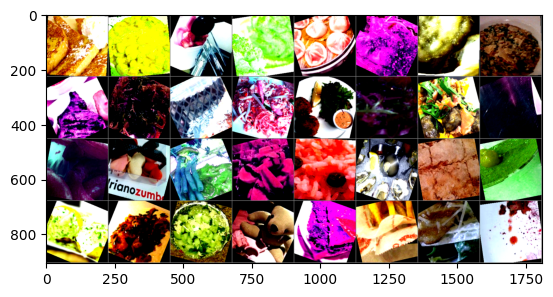

In [13]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)  # 101 classes in Food-101 dataset

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


In [17]:
import time

num_epochs = 15
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(testloader)
    test_losses.append(test_loss)

    accuracy = 100 * correct / total

    end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Time: {end_time - start_time:.2f}s")

    if accuracy >= 85:
        # torch.save(model.state_dict(), f'model_{epoch+1}.pth')
        print(f"Achieved 75% accuracy at epoch {epoch+1}")


print('Finished Training')


Epoch 1/15, Train Loss: 1.3662, Test Loss: 0.7674, Accuracy: 78.88%, Time: 397.39s
Epoch 2/15, Train Loss: 1.3137, Test Loss: 0.7143, Accuracy: 79.96%, Time: 397.02s
Epoch 3/15, Train Loss: 1.2716, Test Loss: 0.7052, Accuracy: 80.32%, Time: 397.16s
Epoch 4/15, Train Loss: 1.2407, Test Loss: 0.6809, Accuracy: 81.13%, Time: 397.14s
Epoch 5/15, Train Loss: 1.1955, Test Loss: 0.6631, Accuracy: 81.78%, Time: 397.15s
Epoch 6/15, Train Loss: 1.1588, Test Loss: 0.6630, Accuracy: 81.75%, Time: 397.29s
Epoch 7/15, Train Loss: 1.1387, Test Loss: 0.6392, Accuracy: 82.28%, Time: 397.44s
Epoch 8/15, Train Loss: 1.1148, Test Loss: 0.6309, Accuracy: 82.52%, Time: 397.15s
Epoch 9/15, Train Loss: 1.0812, Test Loss: 0.6379, Accuracy: 82.50%, Time: 397.18s
Epoch 10/15, Train Loss: 1.0620, Test Loss: 0.6383, Accuracy: 82.48%, Time: 397.24s
Epoch 11/15, Train Loss: 1.0433, Test Loss: 0.6159, Accuracy: 82.99%, Time: 397.34s
Epoch 12/15, Train Loss: 1.0150, Test Loss: 0.6345, Accuracy: 82.63%, Time: 397.13s
E

In [18]:
torch.save(model.state_dict(), f'model_final.pth')

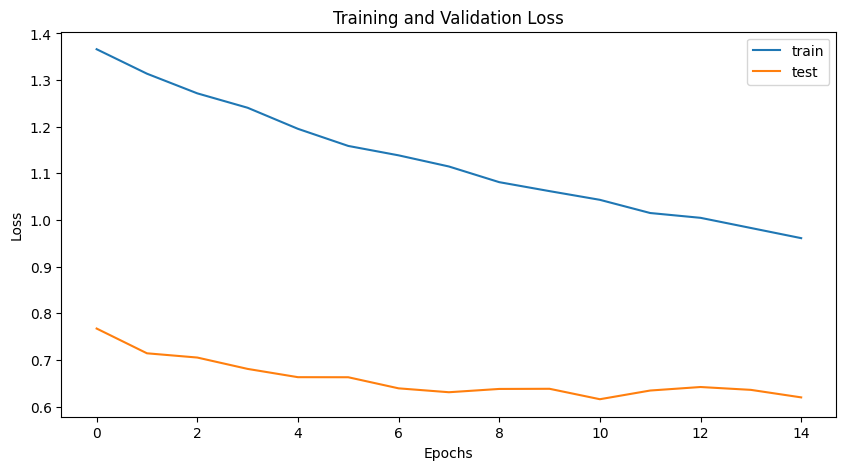

In [19]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms.functional import to_pil_image

In [54]:
def plot_confusion_matrix(model, dataloader, class_names, device='cuda'):
    # Set the model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    # Disable gradients
    with torch.no_grad():
        for images, labels in dataloader:
            # Move the images and labels to the specified device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Display confusion matrix
    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust the figure size as needed
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.show()

In [55]:
FOOD101_CLASSES = ['Apple Pie', 'Baby Back Ribs', 'Baklava', 'Beef Carpaccio',
                   'Beef Tartare', 'Beet Salad', 'Beignets', 'Bibimbap', 'Bread Pudding',
                   'Breakfast Burrito', 'Bruschetta', 'Caesar Salad', 'Cannoli', 'Caprese Salad',
                   'Carrot Cake', 'Ceviche', 'Cheesecake', 'Cheese Plate', 'Chicken Curry',
                   'Chicken Quesadilla', 'Chicken Wings', 'Chocolate Cake', 'Chocolate Mousse', 'Churros', 'Clam Chowder',
                   'Club Sandwich', 'Crab Cakes', 'Creme Brulee', 'Croque Madame', 'Cup Cakes', 'Deviled Eggs', 'Donuts',
                   'Dumplings', 'Edamame', 'Eggs Benedict', 'Escargots', 'Falafel', 'Filet Mignon', 'Fish And Chips',
                   'Foie Gras', 'French Fries', 'French Onion Soup', 'French Toast', 'Fried Calamari', 'Fried Rice',
                   'Frozen Yogurt', 'Garlic Bread', 'Gnocchi', 'Greek Salad', 'Grilled Cheese Sandwich', 'Grilled Salmon',
                   'Guacamole', 'Gyoza', 'Hamburger', 'Hot And Sour Soup', 'Hot Dog', 'Huevos Rancheros', 'Hummus', 'Ice Cream',
                   'Lasagna', 'Lobster Bisque', 'Lobster Roll Sandwich', 'Macaroni And Cheese', 'Macarons', 'Miso Soup', 'Mussels',
                   'Nachos', 'Omelette', 'Onion Rings', 'Oysters', 'Pad Thai', 'Paella', 'Pancakes', 'Panna Cotta', 'Peking Duck',
                   'Pho', 'Pizza', 'Pork Chop', 'Poutine', 'Prime Rib', 'Pulled Pork Sandwich', 'Ramen', 'Ravioli', 'Red Velvet Cake',
                   'Risotto', 'Samosa', 'Sashimi', 'Scallops', 'Seaweed Salad', 'Shrimp And Grits', 'Spaghetti Bolognese',
                   'Spaghetti Carbonara', 'Spring Rolls', 'Steak', 'Strawberry Shortcake', 'Sushi', 'Tacos', 'Takoyaki',
                   'Tiramisu', 'Tuna Tartare', 'Waffles']

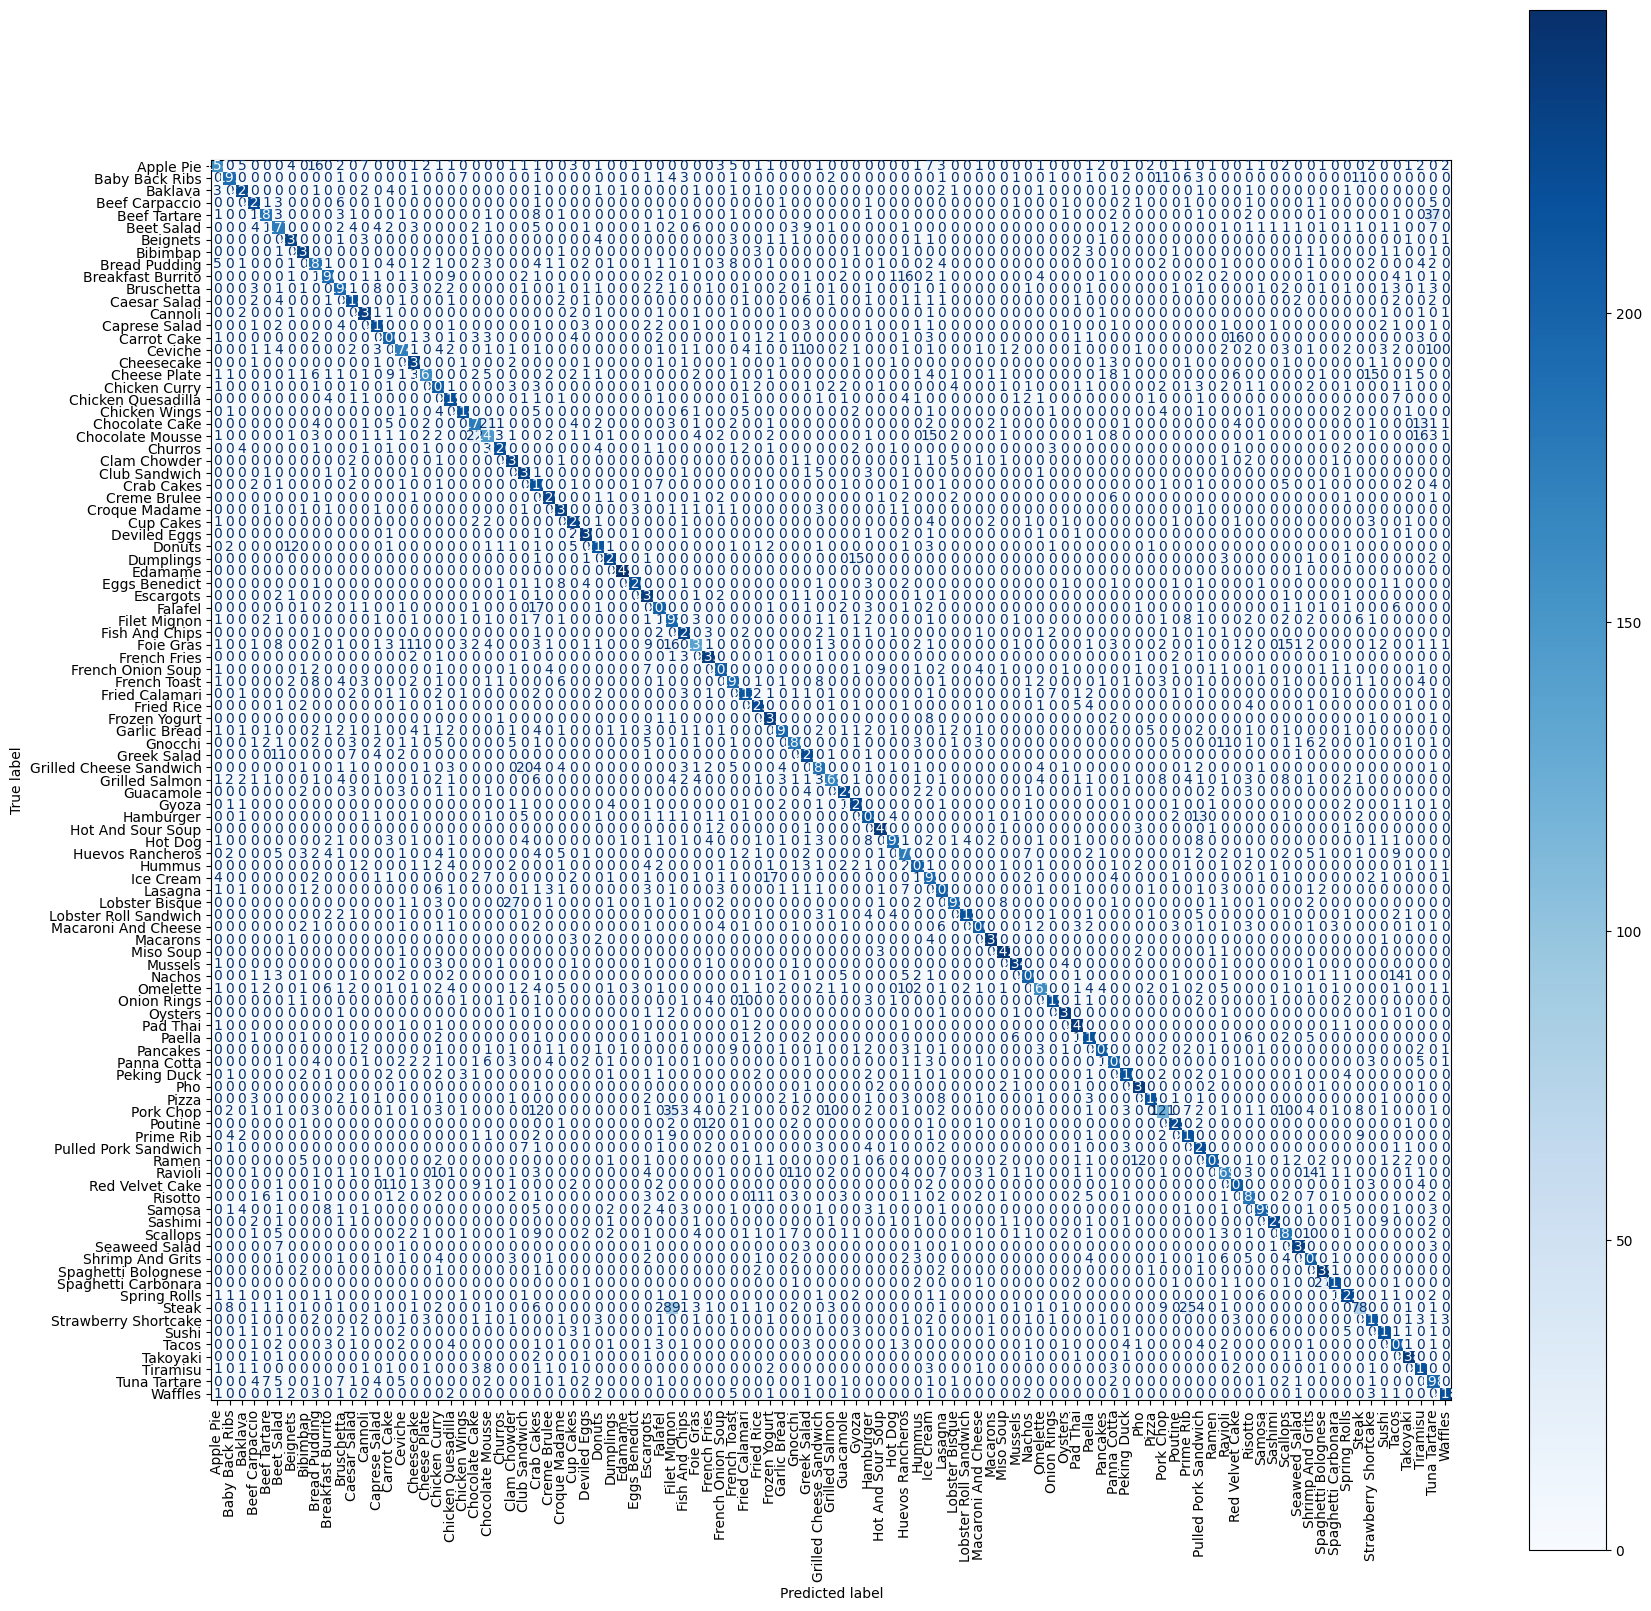

In [56]:
# Plot the confusion matrix for the test dataset
plot_confusion_matrix(model, testloader, FOOD101_CLASSES, device='cuda')